In [2]:
import tensorflow as tf
import pandas as pd

from os.path import expanduser

SRC_PATH = expanduser("~") + '/SageMaker/mastering-ml-on-aws/chapter10/'


In [3]:
from sklearn.model_selection import train_test_split

housing_df = pd.read_csv(SRC_PATH + 'train.csv')
training_df, test_df = train_test_split(housing_df, test_size=0.2)

training_df.head()


,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
90,134,0.32982,0.0,21.89,0,0.624,5.822,95.4,2.4699,4,437,21.2,388.69,15.03,18.4
153,225,0.31533,0.0,6.20,0,0.504,8.266,78.3,2.8944,8,307,17.4,385.05,4.14,44.8
9,15,0.63796,0.0,8.14,0,0.538,6.096,84.5,4.4619,4,307,21.0,380.02,10.26,18.2
22,40,0.02763,75.0,2.95,0,0.428,6.595,21.8,5.4011,3,252,18.3,395.63,4.32,30.8
258,393,11.57790,0.0,18.10,0,0.700,5.036,97.0,1.7700,24,666,20.2,396.90,25.68,9.7


In [4]:
training_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat']
label = 'medv'


In [61]:
distribution = tf.contrib.distribute.MirroredStrategy(num_gpus=4)
config = tf.estimator.RunConfig(train_distribute=distribution)
tf_regressor = tf.estimator.LinearRegressor(
    config=config,
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001),
    feature_columns=[tf.feature_column.numeric_column('inputs', shape=(11,))],
)


INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnja4ig82', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.mirrored_strategy.MirroredStrategy object at 0x7f1ae462eac8>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ae462ec50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replica

In [68]:
def training_input_fn():
    return tf.data.Dataset.from_tensor_slices(
        ({'inputs': training_df[training_features].as_matrix()}, training_df[label].as_matrix())).repeat(50).batch(1)

tf_regressor.train(input_fn=training_input_fn)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnja4ig82/model.ckpt-3325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3325 into /tmp/tmpnja4ig82/model.ckpt.
INFO:tensorflow:loss = 723.9987, step = 3325
INFO:tensorflow:global_step/sec: 277.783
INFO:tensorflow:loss = 612.1852, step = 3425 (0.361 sec)
INFO:tensorflow:global_step/sec: 446.739
INFO:tensorflow:loss = 276.69772, step = 3525 (0.224 sec)
INFO:tensorflow:global_step/sec: 441.015
INFO:tensorflow:loss = 497.48373, step = 3625 (0.227 sec)
INFO:tensorflow:global_step/sec: 447.19
INFO:tenso

In [63]:
rm -rf /tmp/tmpnja4ig82/

In [65]:
def test_input_fn():
    return tf.data.Dataset.from_tensor_slices(
        ({'inputs': test_df[training_features].as_matrix()}, test_df[label].as_matrix())).repeat(1).batch(1)

predictions = tf_regressor.predict(input_fn=test_input_fn)
predicted_values = [prediction['predictions'][0] for prediction in predictions]
test_df['prediction'] = predicted_values


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnja4ig82/model.ckpt-3325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
%matplotlib inline

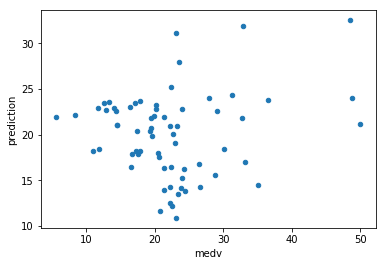

In [67]:

test_df.plot(kind='scatter', x=label, y='prediction')
